# Comparing models

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Parameters

In [2]:
BATCH_SIZE = 24
NUM_CLASSES = 64
NUM_FRAMES = 16
EPOCHS = 50
LR = 0.001

## Set up MLflow connection

In [3]:
import mlflow
import os

from mlflow.entities import Experiment
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_SERVER_URI = "http://localhost:5001"

os.environ["AWS_ACCESS_KEY_ID"] = "miniouser"
os.environ["AWS_SECRET_ACCESS_KEY"] = "miniopass"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000/"

mlflow.set_tracking_uri(MLFLOW_TRACKING_SERVER_URI)
mlflow_client = MlflowClient(MLFLOW_TRACKING_SERVER_URI)

## Load model

In [4]:
def get_run_id(exp_name, run_name) -> str:
    experiment: Experiment = mlflow.set_experiment(experiment_name=exp_name)
    run = None

    matching_runs = mlflow_client.search_runs(
        experiment_ids=[experiment.experiment_id],
        filter_string=f"tags.mlflow.runName = '{run_name}'"
    )

    if len(matching_runs) > 0:
        run = matching_runs[0]
        return run.info.run_id
    else:
        raise Exception("Run inexistente!!!!!")

In [5]:
modelo_B_metadata = {
    "exp_name": "3D Alternate 01",
    "run_name": "Execution 10",
    "run_id": None,
    "model_path": "3D Alternate 01_Execution 10.pth",
}

modelo_B_metadata["run_id"] = get_run_id(exp_name=modelo_B_metadata["exp_name"], run_name=modelo_B_metadata["run_name"])

modelo_B_metadata["run_id"]

'642d531a2c494c3493bc192f46a68c0a'

In [6]:
def load_state_dict(run_id: str, model_path: str):
    return mlflow_client.download_artifacts(
        run_id=run_id,
        path=model_path,
    )

In [7]:
import torch

from recognizer.models.alternate_3d import Alt3DCNN_v2

modelo_B = Alt3DCNN_v2(num_classes=NUM_CLASSES, num_frames=NUM_FRAMES, batch_size=BATCH_SIZE, input_shape=(3, 16, 216, 384))

modelo_B.load_state_dict(
    torch.load(load_state_dict(run_id=modelo_B_metadata["run_id"], model_path=modelo_B_metadata["model_path"]))
)

modelo_B.to("cuda")

INFO:botocore.credentials:Found credentials in environment variables.


Alt3DCNN_v2(
  (conv_layer_1): Sequential(
    (0): Conv3d(3, 4, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): Sequential(
    (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (3): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): Sequential(
    (0): Conv3d(8, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (3): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layer): Sequential(

In [43]:
from recognizer.models.alternate_3d import Alt3DCNN_v2
from recognizer.utils.constants import ROOT_DIR

MODELS_DIR = ROOT_DIR / "models"

modelo_B = Alt3DCNN_v2(num_classes=NUM_CLASSES, num_frames=NUM_FRAMES, batch_size=BATCH_SIZE, input_shape=(3, 16, 216, 384))

modelo_B.load_state_dict(torch.load(str(MODELS_DIR / "3D Alternate 01_Execution 10.pth")))

modelo_B.to("cuda")

Alt3DCNN_v2(
  (conv_layer_1): Sequential(
    (0): Conv3d(3, 4, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): Sequential(
    (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (3): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): Sequential(
    (0): Conv3d(8, 12, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (3): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layer): Sequential(

In [44]:
dummy_input = torch.randn(24, 3, 16, 216, 384).cuda()

output = modelo_B(dummy_input)

print("Output shape:", output.shape)  # Should be [24, 64]

Output shape: torch.Size([24, 64])


In [45]:
from torchsummary import summary

summary(modelo_B, (3, 16, 216, 384), -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 4, 16, 216, 384]           1,504
              ReLU-2      [-1, 4, 16, 216, 384]               0
         MaxPool3d-3       [-1, 4, 9, 109, 193]               0
       BatchNorm3d-4       [-1, 4, 9, 109, 193]               8
            Conv3d-5       [-1, 8, 9, 109, 193]             872
              ReLU-6       [-1, 8, 9, 109, 193]               0
         MaxPool3d-7         [-1, 8, 9, 55, 97]               0
       BatchNorm3d-8         [-1, 8, 9, 55, 97]              16
            Conv3d-9        [-1, 12, 9, 55, 97]           2,604
             ReLU-10        [-1, 12, 9, 55, 97]               0
        MaxPool3d-11        [-1, 12, 9, 28, 49]               0
      BatchNorm3d-12        [-1, 12, 9, 28, 49]              24
           Linear-13                  [-1, 100]      14,817,700
             ReLU-14                  [

## Load a testing set

In [46]:
import pandas as pd

from recognizer.utils.constants import ROOT_DIR, TARGET_TO_ENCODING
from recognizer.utils.utils import get_metadata_from_filename

DATASET_DIR_POSTA = ROOT_DIR / "data" / "all-20percent"

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR_POSTA):

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR_POSTA / file).resolve()))


metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata["target_encoding"] = metadata["target"].map(TARGET_TO_ENCODING)

metadata.head()

,target,subject,repetition,file,target_encoding
0,001,001,001,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
1,001,001,002,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
2,001,001,003,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
3,001,001,004,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
4,001,001,005,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0


### Pre-processing functions

In [47]:
def transform(x):
    """Permutes the element to match the format expected by PyTorch: (C<channels>, T<frames>, H<height>, W<width>)"""
    # Transpose video from (T<frames>, H<height>, W<width>, C<channels>) to (C<channels>, T<frames>, H<height>, W<width>)
    return x.permute(3, 0, 1, 2).float()


In [48]:
def load_testing_set_index(run_id: str):
    local_path = mlflow_client.download_artifacts(
        run_id=run_id,
        path="testing set index.txt",
    )

    with open(local_path, encoding="utf-8") as f:
        return f. read()

In [49]:
import re

test_idx_str_B = load_testing_set_index(
    run_id=modelo_B_metadata["run_id"],
)

test_idx_B = [int(x) for x in re.findall(r'\d+', test_idx_str_B)]

assert len(test_idx_B) == 640

In [50]:
testing_set_B = metadata.loc[test_idx_B]

testing_set_B.groupby("target")["subject"].count()

target
001    10
002    10
003    10
004    10
005    10
       ..
060    10
061    10
062    10
063    10
064    10
Name: subject, Length: 64, dtype: int64

In [51]:
from recognizer.dataset import SampledVideoDataset

In [52]:
testing_dataset_B = SampledVideoDataset(
    video_filenames=testing_set_B["file"].values,
    labels=testing_set_B["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)
test_loader_B = torch.utils.data.DataLoader(testing_dataset_B, batch_size=BATCH_SIZE, shuffle = False)

In [53]:
from torch import nn

loss_function = nn.CrossEntropyLoss()
device = "cuda"

### Make inferences again

In [54]:
import numpy as np

modelo_B.eval()

all_preds = []
all_targets = []
all_logits = []

running_testing_loss = 0.0

with torch.no_grad():
    for data in test_loader_B:
        inputs, labels = data[0].to(device), data[1].to(device)

        logits = modelo_B(inputs)

        _, preds = torch.max(logits, 1)

        all_preds.append(preds.cpu())
        all_targets.append(labels.cpu())
        all_logits.append(logits.cpu())

        loss = loss_function(logits, labels)
        running_testing_loss += loss.item()

average_testing_loss = running_testing_loss / len(test_loader_B)

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)
all_logits = torch.cat(all_logits)

assert len(all_preds) == len(all_targets) == len(all_logits) == 640
assert len(np.unique(all_targets)) == NUM_CLASSES

## Calculate metrics

### Confusion Matrix

In [55]:
ENCODING_TO_TARGET: dict[int, str] = {v: k for k, v in TARGET_TO_ENCODING.items()}

In [56]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_targets, all_preds)

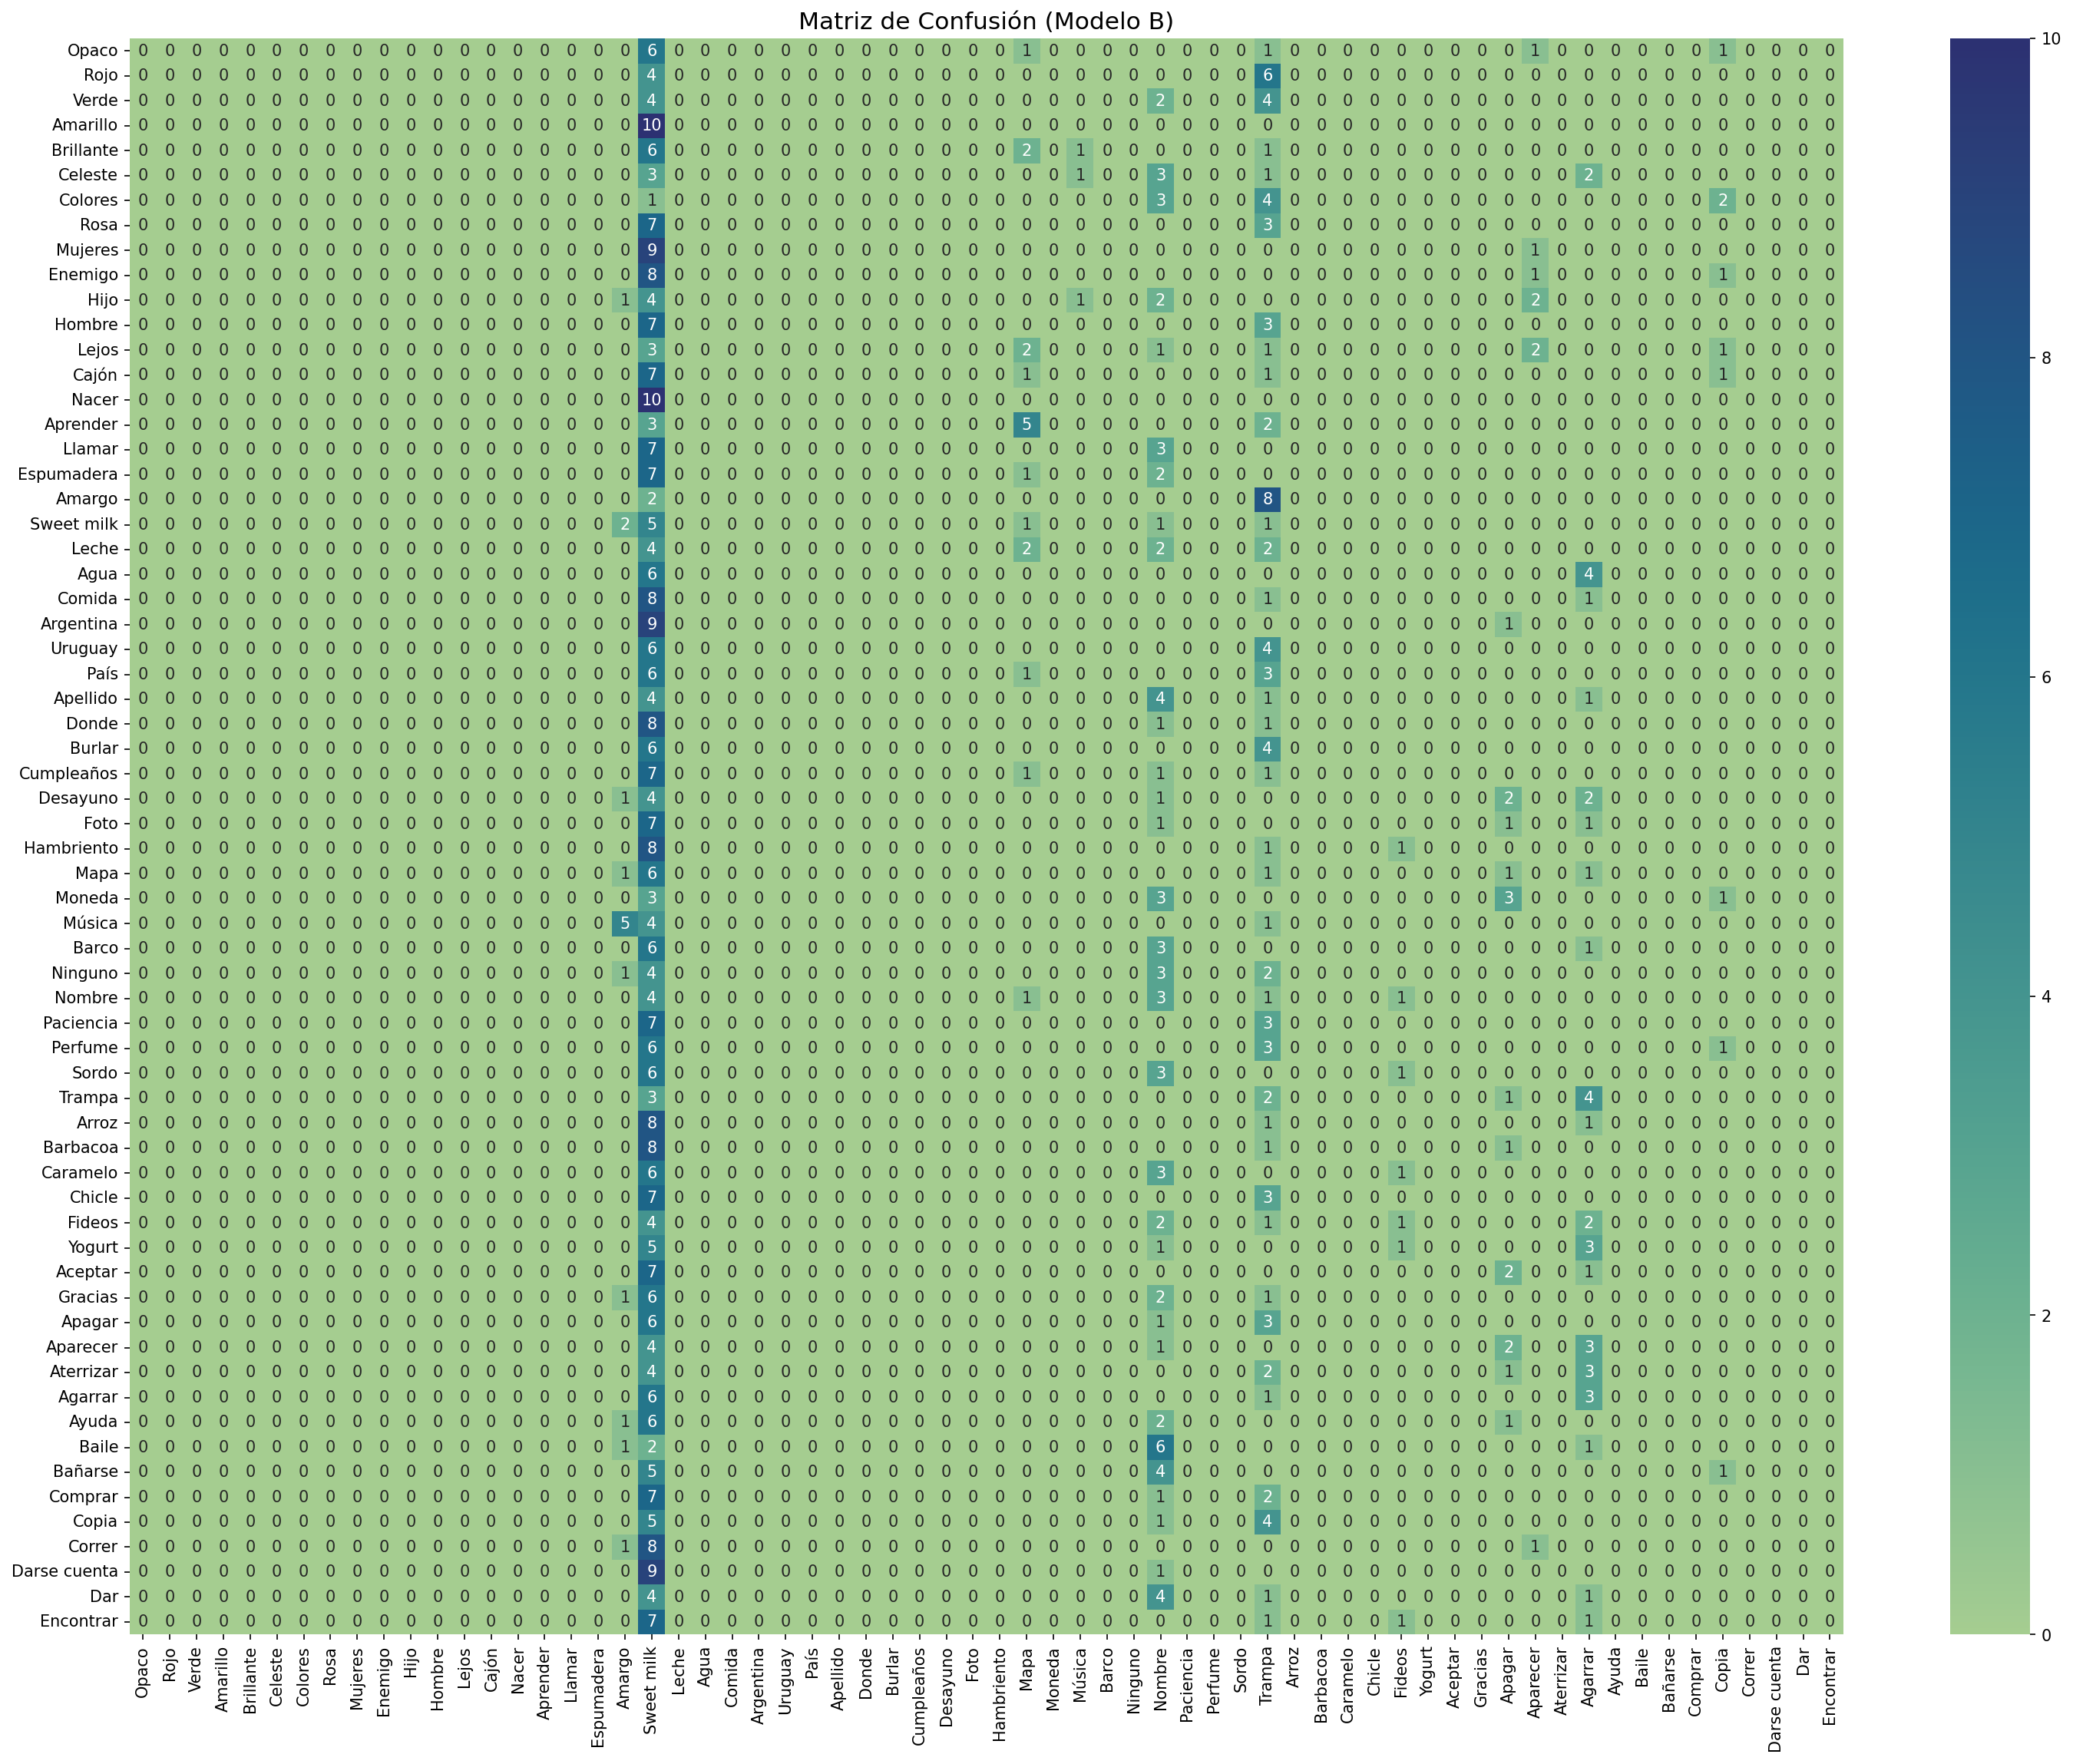

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

from recognizer.utils.constants import TARGET_TO_WORD_ES


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 18), dpi=150, facecolor="white")

heatmap = sns.heatmap(data=cm, ax=ax, annot=True, cmap=sns.color_palette("crest", as_cmap=True))

x_ticks = [int(label.get_text()) for label in heatmap.get_xticklabels()]
y_ticks = [int(label.get_text()) for label in heatmap.get_yticklabels()]

x_new_labels = [TARGET_TO_WORD_ES[ENCODING_TO_TARGET[x]] for x in x_ticks]
y_new_labels = [TARGET_TO_WORD_ES[ENCODING_TO_TARGET[y]] for y in y_ticks]

heatmap.set_xticklabels(x_new_labels)
heatmap.set_yticklabels(y_new_labels)

plt.title("Matriz de Confusión (Modelo B)", fontdict={"fontsize": 15})
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()


In [58]:
CLASSES = np.unique(all_preds)

In [59]:
cm.sum(axis=1)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int64)

In [60]:
np.sum(np.delete(cm, 2, axis=0)[:, 2])

0

### Precision/Recall/F1 per class

In [61]:
# We will store the results in a dictionary for easy access later
per_class_precisions = {}
per_class_recalls = {}
per_class_f1s = {}

# Calculate the accuracy for each one of our classes
for idx in CLASSES:
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm[idx, idx]

    false_positives = np.sum(np.delete(cm, idx, axis=0)[:, idx])
    false_negatives = np.sum(np.delete(cm, idx, axis=1)[idx, :])

    word = TARGET_TO_WORD_ES[ENCODING_TO_TARGET[idx]]

    precision = (true_positives) / (true_positives + false_positives)
    recall = (true_positives) / (true_positives + false_negatives)

    per_class_precisions[word] = precision
    per_class_recalls[word] = recall
    per_class_f1s[word] = 2 * (precision * recall) / (precision + recall)

C:\Users\facun\AppData\Local\Temp\ipykernel_10944\2562665306.py:21: RuntimeWarning: invalid value encountered in scalar divide
  per_class_f1s[word] = 2 * (precision * recall) / (precision + recall)


In [62]:
precisions_df = pd.DataFrame.from_dict(per_class_precisions, orient="index", columns=["precision"])
precisions_df.index.name = "word"

recalls_df = pd.DataFrame.from_dict(per_class_recalls, orient="index", columns=["recall"])
recalls_df.index.name = "word"

f1s_df = pd.DataFrame.from_dict(per_class_f1s, orient="index", columns=["f1"])
f1s_df.index.name = "word"

In [63]:
metrics_df = (
    precisions_df
    .merge(recalls_df, how="inner", on="word")
    .merge(f1s_df, how="inner", on="word")
    .reset_index()
)

In [64]:
metrics_df.sort_values("precision", ascending=True).head()

,word,precision,recall,f1
0,Amargo,0.0,0.0,NaN
2,Mapa,0.0,0.0,NaN
3,Música,0.0,0.0,NaN
7,Apagar,0.0,0.0,NaN
8,Aparecer,0.0,0.0,NaN


### ROC AUC

In [65]:
all_preds_proba = nn.functional.softmax(all_logits, dim=1).numpy()

In [66]:
all_preds_proba[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [67]:
from sklearn.preprocessing import label_binarize

y_true = label_binarize(all_targets, classes=range(64))

y_true.shape

(640, 64)

In [68]:
from sklearn.metrics import roc_auc_score


roc_auc_micro = roc_auc_score(y_true, all_preds_proba, average="micro", multi_class="ovr")
roc_auc_macro = roc_auc_score(y_true, all_preds_proba, average="macro", multi_class="ovr")

roc_auc_micro, roc_auc_macro

(0.5056705341641865, 0.5055803571428572)

In [69]:
from sklearn.metrics import auc, roc_curve


fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(64):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_preds_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

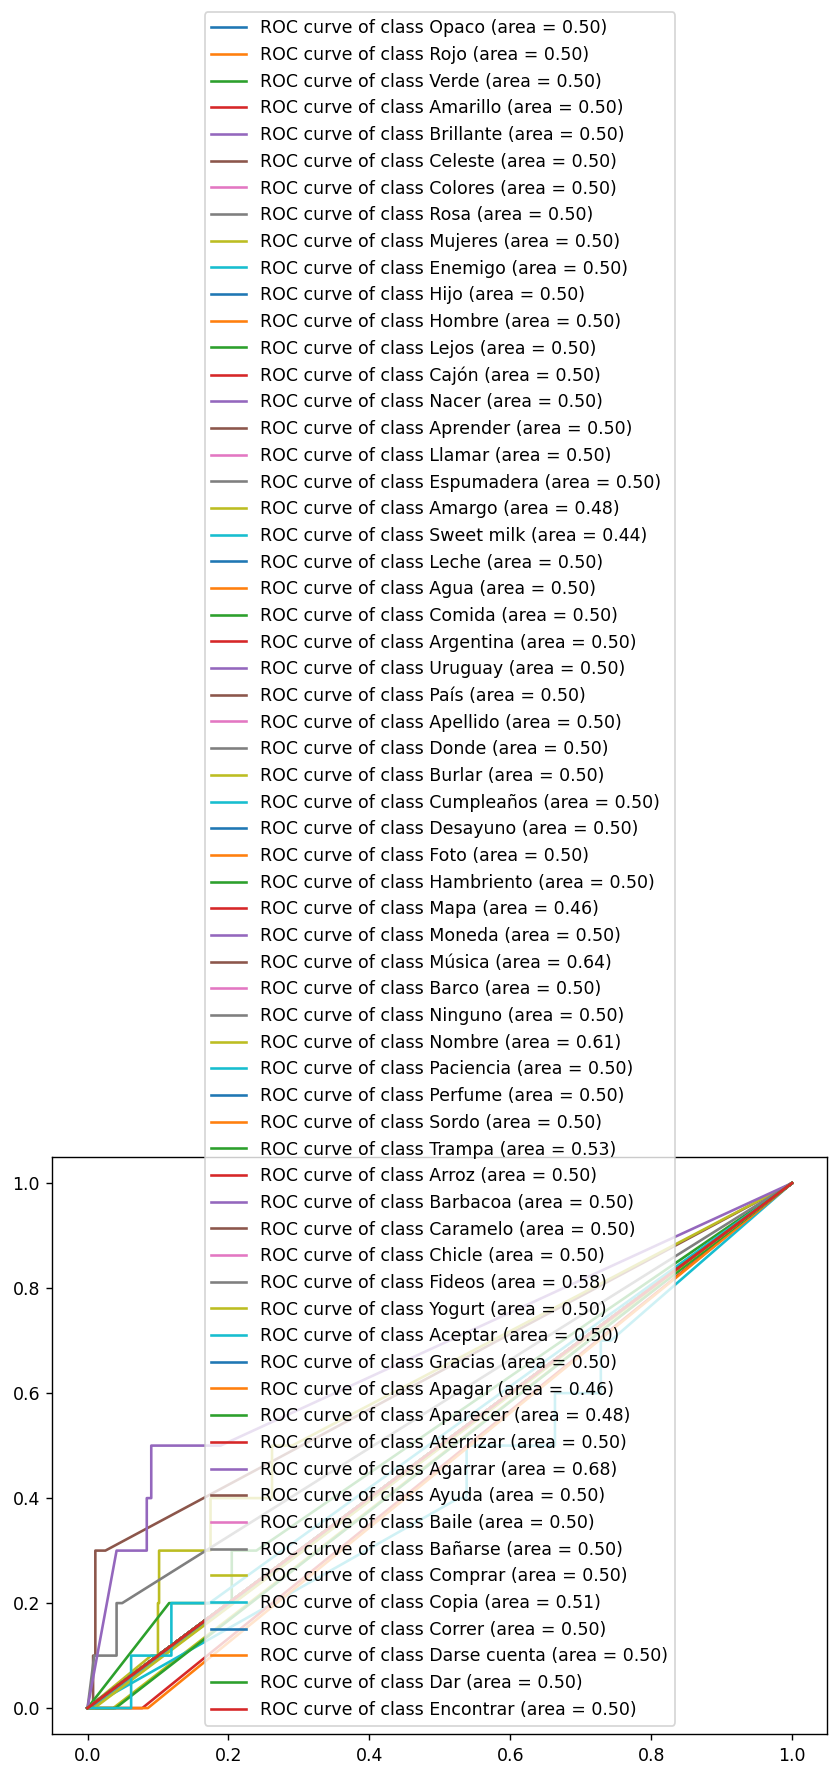

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=125, facecolor="white")

for i in range(64):
    ax.plot(fpr[i], tpr[i], label=f"ROC curve of class {TARGET_TO_WORD_ES[ENCODING_TO_TARGET[i]]} (area = {roc_auc[i]:0.2f})")

ax.legend()
plt.show()

## MLFlow metrics

#### Loss over time

In [71]:
training_losses = mlflow_client.get_metric_history(run_id=modelo_B_metadata["run_id"], key="training_loss")
testing_losses = mlflow_client.get_metric_history(run_id=modelo_B_metadata["run_id"], key="testing_loss")

In [72]:
training_losses = [{'step': metric.step, 'training_loss': metric.value} for metric in training_losses]
testing_losses = [{'step': metric.step, 'testing_loss': metric.value} for metric in testing_losses]

In [73]:
losses_df = (
    pd.DataFrame(training_losses)
    .merge(pd.DataFrame(testing_losses), on="step")
    .sort_values("step")
)

losses_df.head()

,step,training_loss,testing_loss
0,0,3.14,10.87
1,1,1.54,0.96
2,2,0.63,0.42
3,3,0.24,0.38
4,4,0.12,0.16


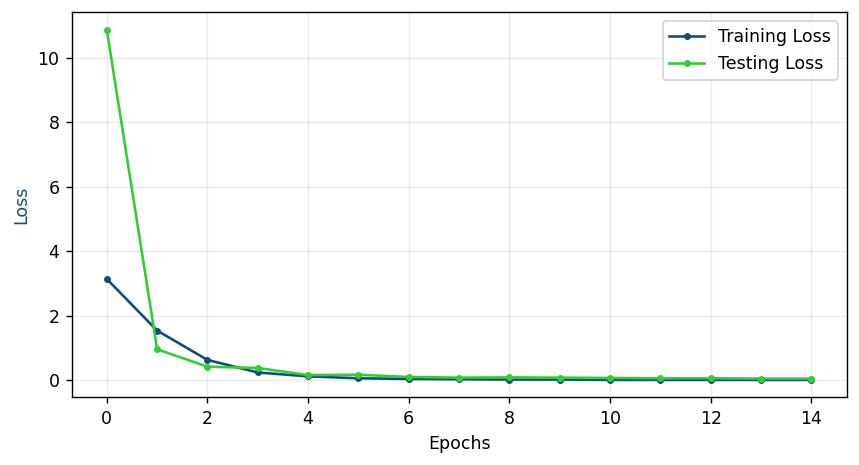

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=125, facecolor="white")

ax.plot(losses_df["step"], losses_df["training_loss"], label=f"Training Loss", color="#0F4C81", marker=".")
ax.plot(losses_df["step"], losses_df["testing_loss"], label=f"Testing Loss", color="#32CD32", marker=".")

ax.grid(alpha=0.25)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss", color="#0F4C81")
ax.legend()
plt.show()

#### Accuracy/Precision/Recall over time

In [75]:
accuracies_over_time = mlflow_client.get_metric_history(run_id=modelo_B_metadata["run_id"], key="accuracy")
precisions_over_time = mlflow_client.get_metric_history(run_id=modelo_B_metadata["run_id"], key="precision")
recalls_over_time = mlflow_client.get_metric_history(run_id=modelo_B_metadata["run_id"], key="recall")

accuracies_over_time = [{'step': metric.step, 'accuracy': metric.value} for metric in accuracies_over_time]
precisions_over_time = [{'step': metric.step, 'precision': metric.value} for metric in precisions_over_time]
recalls_over_time = [{'step': metric.step, 'recall': metric.value} for metric in recalls_over_time]

metrics_over_time_df = (
    pd.DataFrame(accuracies_over_time)
    .merge(pd.DataFrame(precisions_over_time), on="step")
    .merge(pd.DataFrame(recalls_over_time), on="step")
    .sort_values("step")
)

metrics_over_time_df.head()

,step,accuracy,precision,recall
0,0,0.307812,0.476330,0.307812
1,1,0.929688,0.944741,0.929688
2,2,0.968750,0.971780,0.968750
3,3,0.990625,0.991335,0.990625
4,4,0.990625,0.991193,0.990625


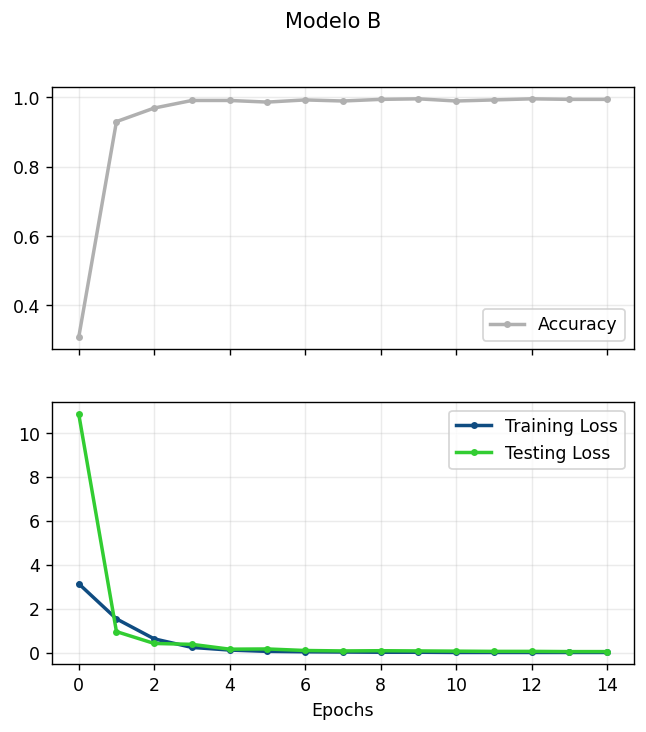

In [77]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), dpi=125, facecolor="white", sharex=True)

line_kwargs = {"marker": ".", "linewidth": 2}

axs[0].plot(metrics_over_time_df["step"], metrics_over_time_df["accuracy"], label=f"Accuracy", color="#B0B0B0", **line_kwargs)
axs[0].legend(loc="lower right")
axs[0].grid(alpha=0.25)

axs[1].plot(losses_df["step"], losses_df["training_loss"], label=f"Training Loss", color="#0F4C81", **line_kwargs)
axs[1].plot(losses_df["step"], losses_df["testing_loss"], label=f"Testing Loss", color="#32CD32", **line_kwargs)

axs[1].set_xlabel("Epochs")
axs[1].legend()
axs[1].grid(alpha=0.25)

fig.suptitle("Modelo B")
plt.show()

### Conf matrix 2

In [79]:
import os
from pathlib import Path
from typing import Literal


def load_preds_or_labels(run_id: str, artifact: Literal["predictions", "ground_truth"]) -> np.ndarray:
    ret_val = None
    artifact_path = mlflow_client.download_artifacts(
        run_id=run_id,
        path=artifact,
    )

    for f in os.listdir(artifact_path):
        data = np.load(Path(artifact_path) / f)
        ret_val = np.concatenate([ret_val, data]) if ret_val is not None else data

    return ret_val

In [80]:
loaded_preds = None
loaded_labels = None

loaded_preds = load_preds_or_labels(run_id=modelo_B_metadata["run_id"], artifact="predictions")
loaded_labels = load_preds_or_labels(run_id=modelo_B_metadata["run_id"], artifact="ground_truth")

loaded_preds.shape, loaded_labels.shape

((640,), (640,))

In [82]:
cm2 = confusion_matrix(loaded_labels, loaded_preds)

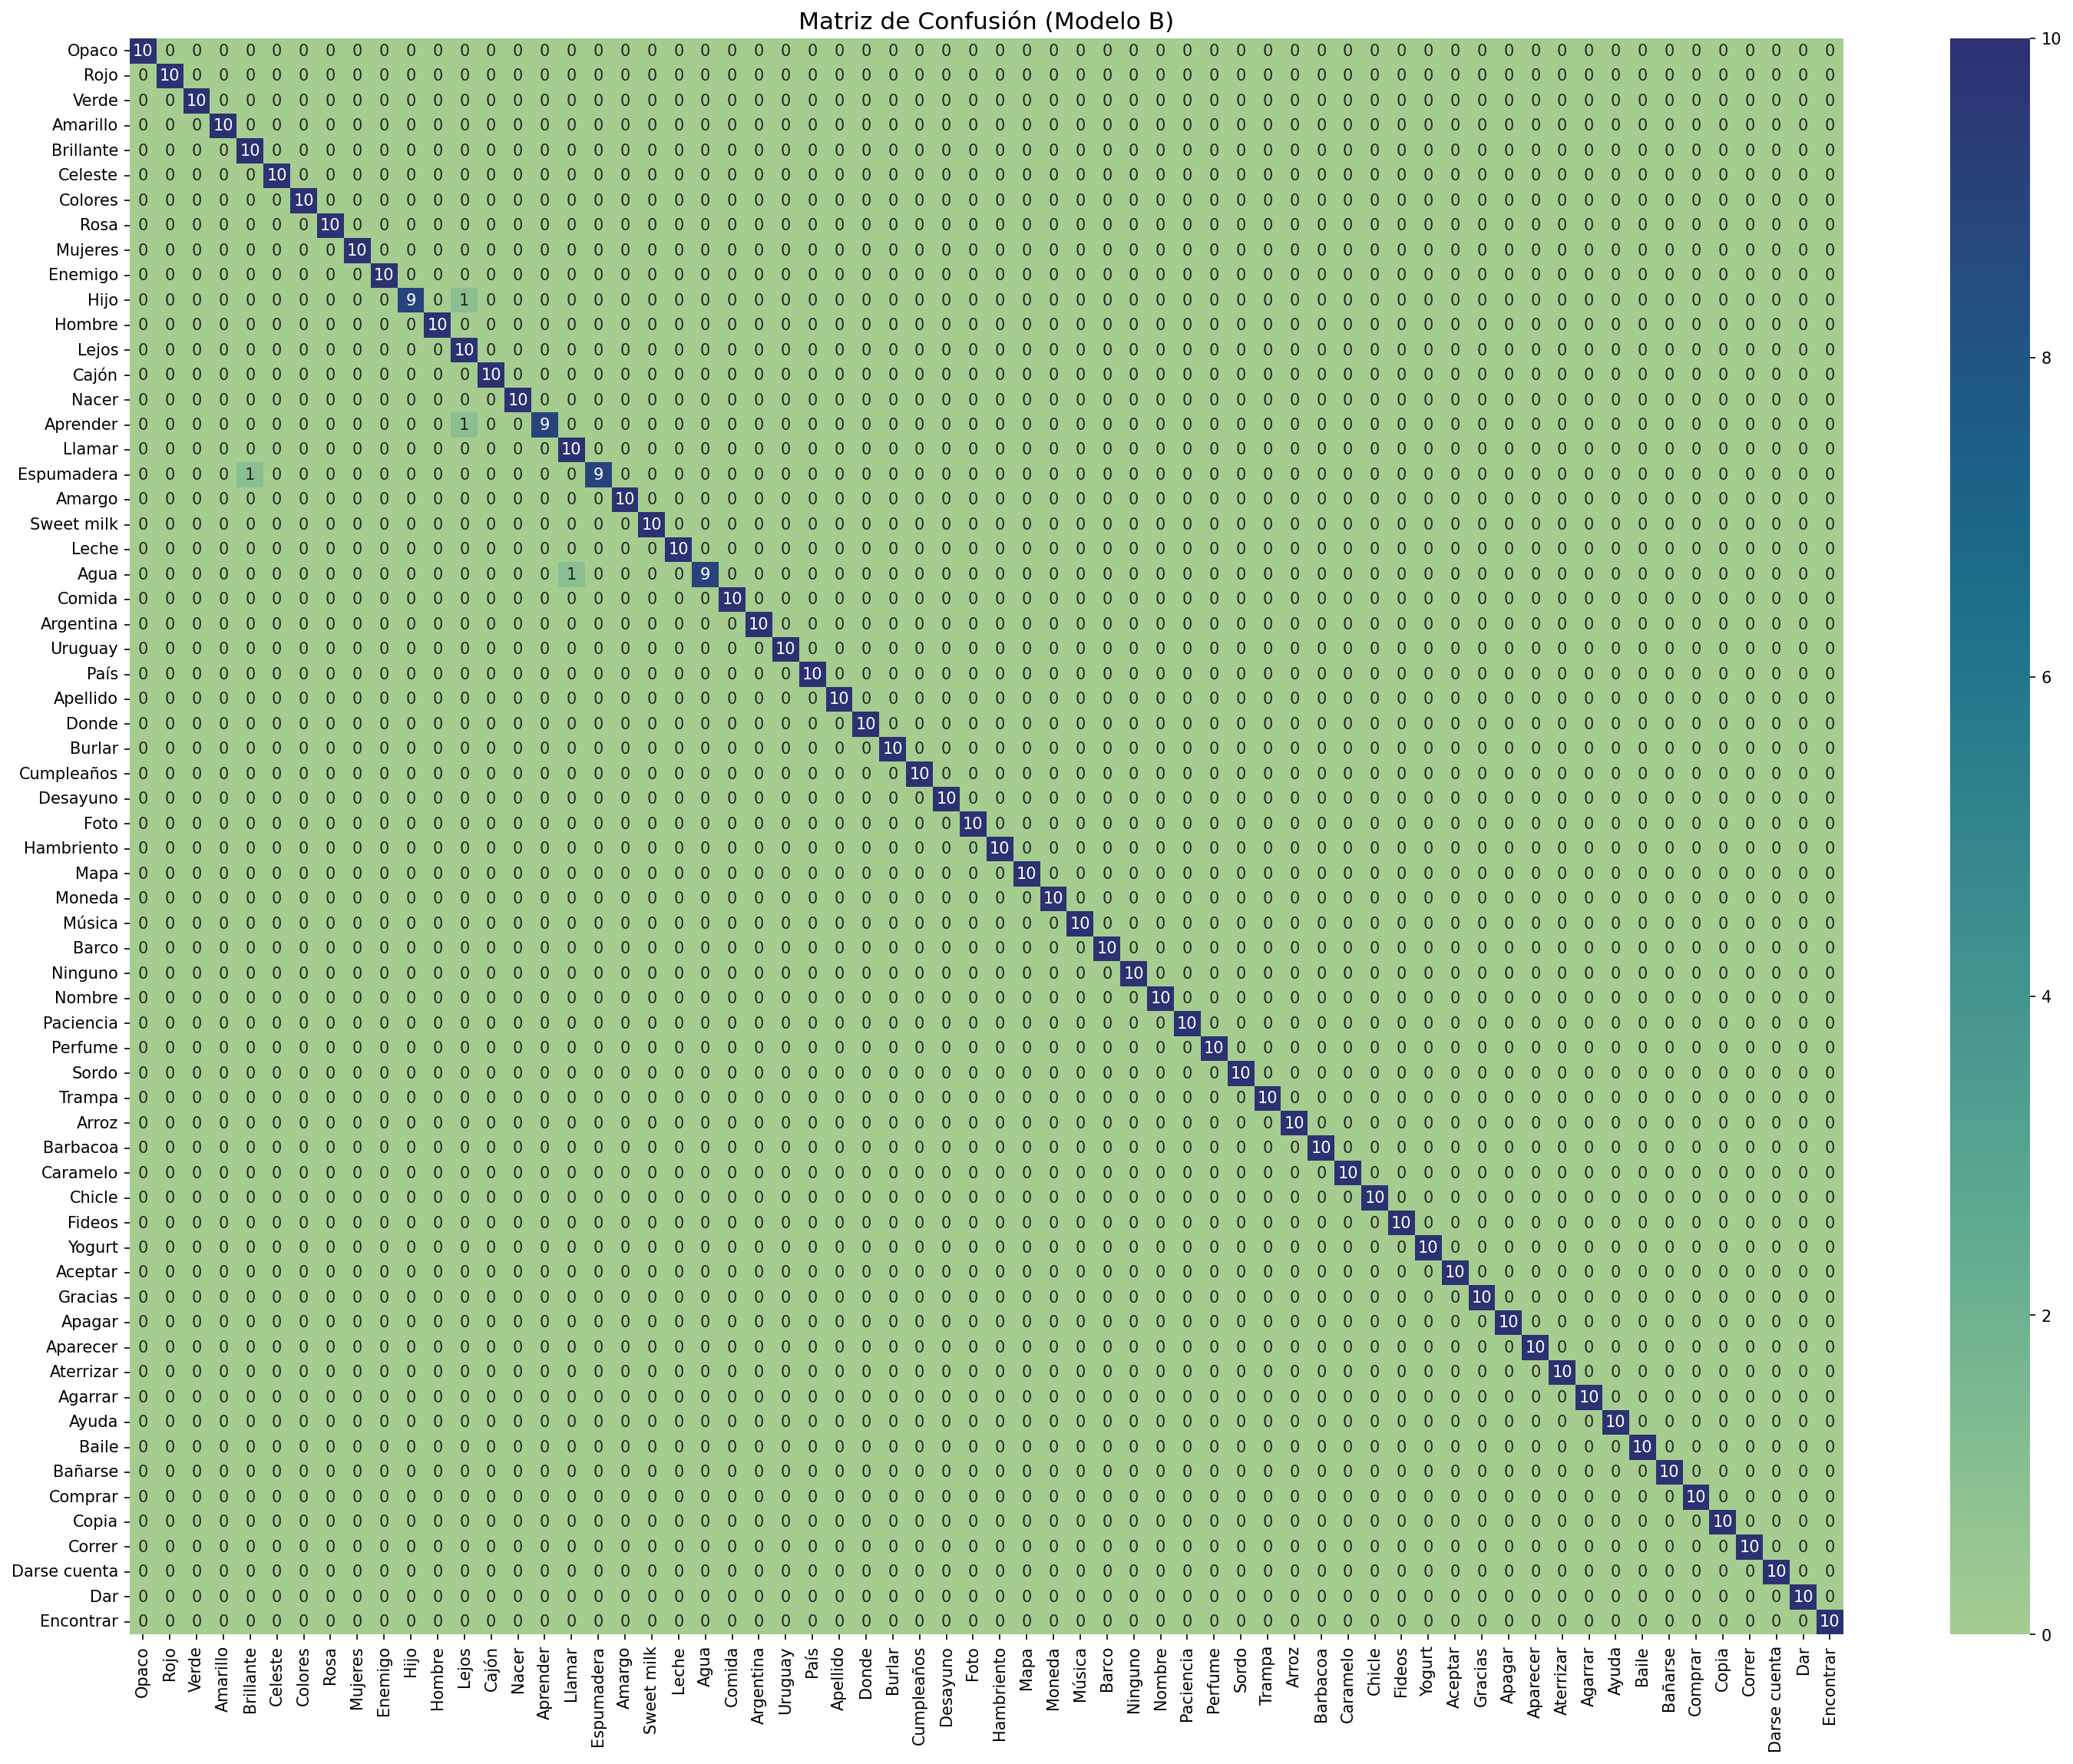

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

from recognizer.utils.constants import TARGET_TO_WORD_ES


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 18), dpi=150, facecolor="white")

heatmap = sns.heatmap(data=cm2, ax=ax, annot=True, cmap=sns.color_palette("crest", as_cmap=True))

x_ticks = [int(label.get_text()) for label in heatmap.get_xticklabels()]
y_ticks = [int(label.get_text()) for label in heatmap.get_yticklabels()]

x_new_labels = [TARGET_TO_WORD_ES[ENCODING_TO_TARGET[x]] for x in x_ticks]
y_new_labels = [TARGET_TO_WORD_ES[ENCODING_TO_TARGET[y]] for y in y_ticks]

heatmap.set_xticklabels(x_new_labels)
heatmap.set_yticklabels(y_new_labels)

plt.title("Matriz de Confusión (Modelo B)", fontdict={"fontsize": 15})
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()


### Precision/Recall/F1 per class

In [100]:
# We will store the results in a dictionary for easy access later
per_class_precisions = {}
per_class_recalls = {}
per_class_f1s = {}

# Calculate the accuracy for each one of our classes
for idx in range(64):
    # True positives are all the samples of our current GT class that were predicted as such
    true_positives = cm2[idx, idx]

    false_positives = np.sum(np.delete(cm2, idx, axis=0)[:, idx])
    false_negatives = np.sum(np.delete(cm2, idx, axis=1)[idx, :])

    word = TARGET_TO_WORD_ES[ENCODING_TO_TARGET[idx]]

    precision = (true_positives) / (true_positives + false_positives)
    recall = (true_positives) / (true_positives + false_negatives)

    per_class_precisions[word] = precision
    per_class_recalls[word] = recall
    per_class_f1s[word] = 2 * (precision * recall) / (precision + recall)

In [101]:
per_class_precisions

{'Opaco': 1.0,
 'Rojo': 1.0,
 'Verde': 1.0,
 'Amarillo': 1.0,
 'Brillante': 0.9090909090909091,
 'Celeste': 1.0,
 'Colores': 1.0,
 'Rosa': 1.0,
 'Mujeres': 1.0,
 'Enemigo': 1.0,
 'Hijo': 1.0,
 'Hombre': 1.0,
 'Lejos': 0.8333333333333334,
 'Cajón': 1.0,
 'Nacer': 1.0,
 'Aprender': 1.0,
 'Llamar': 0.9090909090909091,
 'Espumadera': 1.0,
 'Amargo': 1.0,
 'Sweet milk': 1.0,
 'Leche': 1.0,
 'Agua': 1.0,
 'Comida': 1.0,
 'Argentina': 1.0,
 'Uruguay': 1.0,
 'País': 1.0,
 'Apellido': 1.0,
 'Donde': 1.0,
 'Burlar': 1.0,
 'Cumpleaños': 1.0,
 'Desayuno': 1.0,
 'Foto': 1.0,
 'Hambriento': 1.0,
 'Mapa': 1.0,
 'Moneda': 1.0,
 'Música': 1.0,
 'Barco': 1.0,
 'Ninguno': 1.0,
 'Nombre': 1.0,
 'Paciencia': 1.0,
 'Perfume': 1.0,
 'Sordo': 1.0,
 'Trampa': 1.0,
 'Arroz': 1.0,
 'Barbacoa': 1.0,
 'Caramelo': 1.0,
 'Chicle': 1.0,
 'Fideos': 1.0,
 'Yogurt': 1.0,
 'Aceptar': 1.0,
 'Gracias': 1.0,
 'Apagar': 1.0,
 'Aparecer': 1.0,
 'Aterrizar': 1.0,
 'Agarrar': 1.0,
 'Ayuda': 1.0,
 'Baile': 1.0,
 'Bañarse': 1.0,


In [102]:
precisions_df = pd.DataFrame.from_dict(per_class_precisions, orient="index", columns=["precision"])
precisions_df.index.name = "word"

recalls_df = pd.DataFrame.from_dict(per_class_recalls, orient="index", columns=["recall"])
recalls_df.index.name = "word"

f1s_df = pd.DataFrame.from_dict(per_class_f1s, orient="index", columns=["f1"])
f1s_df.index.name = "word"

In [103]:
metrics_df = (
    precisions_df
    .merge(recalls_df, how="inner", on="word")
    .merge(f1s_df, how="inner", on="word")
    .reset_index()
)

In [104]:
metrics_df.sort_values("precision", ascending=True).head()

,word,precision,recall,f1
12,Lejos,0.833333,1.0,0.909091
16,Llamar,0.909091,1.0,0.952381
4,Brillante,0.909091,1.0,0.952381
46,Chicle,1.000000,1.0,1.000000
45,Caramelo,1.000000,1.0,1.000000


In [105]:
metrics_df.head(64)

,word,precision,recall,f1
0,Opaco,1.000000,1.0,1.000000
1,Rojo,1.000000,1.0,1.000000
2,Verde,1.000000,1.0,1.000000
3,Amarillo,1.000000,1.0,1.000000
4,Brillante,0.909091,1.0,0.952381
...,...,...,...,...
59,Copia,1.000000,1.0,1.000000
60,Correr,1.000000,1.0,1.000000
61,Darse cuenta,1.000000,1.0,1.000000
62,Dar,1.000000,1.0,1.000000
